# Going to Mars with Python using poliastro

<img src="http://docs.poliastro.space/en/latest/_images/logo_text.png" />

This is an example on how to use [poliastro](https://github.com/poliastro/poliastro), a little library I've been working on to use in my Astrodynamics lessons. It features conversion between **classical orbital elements** and position vectors, propagation of **Keplerian orbits**, initial orbit determination using the solution of the **Lambert's problem** and **orbit plotting**.

In this example we're going to draw the trajectory of the mission [Mars Science Laboratory (MSL)](http://mars.jpl.nasa.gov/msl/), which carried the rover Curiosity to the surface of Mars in a period of something less than 9 months.

**Note**: This is a very simplistic analysis which doesn't take into account many important factors of the mission, but can serve as an starting point for more serious computations (and as a side effect produces a beautiful plot at the end).

<div class="alert alert-info">An earlier version of this notebook allowed for more flexibility and interactivity, but was considerably more complex. Future versions of poliastro and plotly might bring back part of that functionality, depending on user feedback. You can still download the older version <a href="https://github.com/poliastro/poliastro/blob/0.7.x/docs/source/examples/Going%20to%20Mars%20with%20Python%20using%20poliastro.ipynb">here</a>.</div>

First of all, we import the necessary modules. Apart from poliastro we will make use of astropy to deal with physical units and time definitions and jplephem to compute the positions and velocities of the planets.

In [1]:
# Temporary hack, see https://github.com/poliastro/poliastro/issues/281
from IPython.display import HTML
HTML('<script type="text/javascript" src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.1.10/require.min.js"></script>')

In [2]:
import numpy as np

import astropy.units as u
from astropy import time

from poliastro import iod
from poliastro.bodies import Sun
from poliastro.twobody import Orbit

from poliastro.util import time_range

We need a binary file from NASA called *SPICE kernel* to compute the position and velocities of the planets. Astropy downloads it for us:

In [3]:
from astropy.coordinates import solar_system_ephemeris, get_body_barycentric_posvel
solar_system_ephemeris.set("jpl")

<ScienceState solar_system_ephemeris: 'jpl'>

The initial data was gathered from Wikipedia: the date of the launch was on **November 26, 2011 at 15:02 UTC** and landing was on **August 6, 2012 at 05:17 UTC**. We compute then the time of flight, which is exactly what it sounds. It is a crucial parameter of the mission.

In [4]:
# Initial data
N = 50

date_launch = time.Time('2011-11-26 15:02', scale='utc')
date_arrival = time.Time('2012-08-06 05:17', scale='utc')
tof = (date_arrival - date_launch)

tof.to(u.h)

<Quantity 6086.25027778 h>

Once we have the vector of times we can use `get_body_barycentric_posvel` to compute the array of positions and velocities of the Earth and Mars.

In [5]:
times_vector = time_range(date_launch, end=date_arrival, periods=N)
times_vector[:5]

<Time object: scale='utc' format='iso' value=['2011-11-26 15:02:00.000' '2011-12-01 19:14:33.082'
 '2011-12-06 23:27:06.163' '2011-12-12 03:39:39.245'
 '2011-12-17 07:52:12.327']>

In [6]:
rr_earth, vv_earth = get_body_barycentric_posvel("earth", times_vector)

In [7]:
rr_earth[:3]

<CartesianRepresentation (x, y, z) in km
    [(64600643.37167563, 1.21424866e+08, 52640047.33041222),
     (52175250.21264037, 1.26254284e+08, 54733247.42732787),
     (39319701.40598051, 1.30036609e+08, 56373071.6065251 )]>

In [8]:
vv_earth[:3]

<CartesianRepresentation (x, y, z) in km / d
    [(-2352414.27027126, 1032013.3380897 , 447276.92493007),
     (-2445842.68494247,  833043.95148986, 361105.49364196),
     (-2518740.18681062,  627712.9008316 , 272197.06320273)]>

In [9]:
rr_mars, vv_mars = get_body_barycentric_posvel("mars", times_vector)

In [10]:
rr_mars[:3]

<CartesianRepresentation (x, y, z) in km
    [(-1.23149631e+08, 1.90752511e+08, 90809654.2669948 ),
     (-1.31992428e+08, 1.86383187e+08, 89044491.25204735),
     (-1.40598005e+08, 1.81677346e+08, 87118570.32883616)]>

In [11]:
vv_mars[:3]

<CartesianRepresentation (x, y, z) in km / d
    [(-1730626.66251077, -811069.96095538, -325255.37513281),
     (-1686163.26853493, -877100.53950512, -356742.77622963),
     (-1638971.32577256, -941103.98130274, -387374.07466148)]>

<div class="alert alert-info">The positions and velocities are in the <strong>International Standard Reference Frame</strong>, which has the Equator as the fundamental plane</div>

To compute the transfer orbit, we have the useful function `lambert`: according to a theorem with the same name, *the transfer orbit between two points in space only depends on those two points and the time it takes to go from one to the other*. We have the starting and final position and we have the time of flight: there we go!

In [12]:
# Compute the transfer orbit!
r0 = rr_earth[0].xyz
rf = rr_mars[-1].xyz

(va, vb), = iod.lambert(Sun.k, r0, rf, tof)

ss0_trans = Orbit.from_vectors(Sun, r0, va, date_launch)
ssf_trans = Orbit.from_vectors(Sun, rf, vb, date_arrival)

And finally, we can plot the figure! There is no more magic here, just passing the position vectors to matplotlib `plot` function and adding some style to the plot.

Warning : Please make sure to include these lines while running this on Jupyter Notebook or on an older version of plotly (< 3.0)

In [13]:
# from plotly.offline import init_notebook_mode
# init_notebook_mode(connected=True)

In [14]:
from poliastro.plotting import OrbitPlotter3D
from poliastro.bodies import Earth, Mars

In [15]:
# I like color
color_earth0 = '#3d4cd5'
color_earthf = '#525fd5'
color_mars0 = '#ec3941'
color_marsf = '#ec1f28'
color_sun = '#ffcc00'
color_orbit = '#888888'
color_trans = '#444444'

frame = OrbitPlotter3D()

frame.set_attractor(Sun)

frame.plot_trajectory(rr_earth, label=Earth, color=color_earth0)
frame.plot_trajectory(rr_mars, label=Mars, color=color_marsf)

frame.plot_trajectory(ss0_trans.sample(times_vector)[-1], label="MSL trajectory", color=color_trans)

frame.set_view(30 * u.deg, 260 * u.deg, distance=3 * u.km)
frame.show(title="MSL Mission: from Earth to Mars")

This line opens a new browser tab and saves the resulting image:

In [16]:
#frame.savefig("msl3d.png", title="MSL Mission: from Earth to Mars")

Not bad! Let's celebrate with some music!

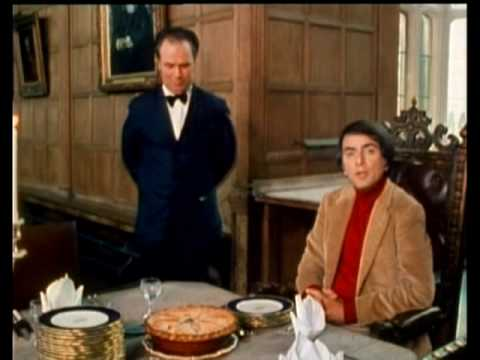

In [17]:
from IPython.display import YouTubeVideo
YouTubeVideo('zSgiXGELjbc')